# LuxonisDatasetFormat - testing embeddings methods

In [1]:
import os
import uuid
import numpy as np
import onnx
import onnxruntime
import torch
import torch.onnx
import torchvision
from matplotlib import pyplot as plt
from utils.data_utils import load_mnist_data

# only for local testing
import sys
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
sys.path.append('/home/paperspace/Luxonis/luxonis-ml')

from luxonis_ml.data import (
    LuxonisDataset,
    LuxonisLoader,
)
from luxonis_ml.embeddings.utils.embedding import (
    extract_embeddings,
    extract_embeddings_onnx,
    load_embeddings,
    save_embeddings,
)
from luxonis_ml.embeddings.utils.ldf import generate_embeddings_weaviate
from luxonis_ml.embeddings.utils.model import (
    export_model_onnx,
    extend_output_onnx,
    load_model,
    load_model_onnx,
    load_model_resnet50_minuslastlayer,
)
from luxonis_ml.embeddings.utils.weaviate import WeaviateAPI

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pytorch examples

In [2]:
# Load the data
data_loader = load_mnist_data(save_path="./mnist", num_samples=640, batch_size=64)

In [3]:
# Load the model
model = load_model_resnet50_minuslastlayer()

In [4]:
# Extract embeddings from the dataset
embeddings, labels = extract_embeddings(model, data_loader)

In [5]:
save_embeddings(embeddings, labels)

## ONNX models and Weaviate

In [6]:
# Load the data
data_loader = load_mnist_data(save_path="./mnist", num_samples=640, batch_size=64)

In [7]:
# Load the model
model = load_model()

# Export the model to ONNX
export_model_onnx(model, model_path_out="resnet50.onnx")

# Load the ONNX model
onnx_model = load_model_onnx(model_path="resnet50.onnx")

# Extend the ONNX model with an intermediate output layer
onnx_model = extend_output_onnx(
    onnx_model, intermediate_tensor_name="/Flatten_output_0"
)

# Save the ONNX model
onnx.save(onnx_model, "resnet50-1.onnx")

In [8]:
# Create an ONNX Runtime session
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_onnx(
    ort_session, data_loader, "/Flatten_output_0"
)

# Save the embeddings and labels to a file
save_embeddings(embeddings, labels)

2024-01-16 15:18:41.934165486 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [9]:
embeddings, labels = load_embeddings()
# must be list
embeddings = embeddings.tolist()
labels = labels.tolist()
labels = [str(label) for label in labels]

In [10]:
# Connect to Weaviate
weaviate_api = WeaviateAPI("http://localhost:8080")
# weaviate_api = WeaviateAPI(url="http://localhost:8080", auth_key="YOUR_AUTH_KEY")

In [11]:
# Create a collection
weaviate_api.create_collection("Mnist", label=True)

# Insert the embeddings into the collection
uuids = [str(uuid.uuid4()) for _ in range(len(labels))]
weaviate_api.insert_embeddings(uuids, embeddings, labels, batch_size=50)

In [12]:
# Search for the nearest neighbors
search_uuids = weaviate_api.find_similar_embeddings(embeddings[0], k=5)
search_labels = weaviate_api.get_labels(search_uuids)

# Print the search results
for u,l in zip(search_uuids, search_labels):
    print(u, l)

05437b67-09d8-47df-8e87-d71723c4a1a0 6
6c963481-aa68-44e5-b53f-94713fccb9b4 6
9aaa8c34-baeb-4faa-8e37-4f8e33a42cf4 6
6168efe0-413b-45a6-bba2-977fc396f623 6
b919290d-db3f-4f57-a9a6-1ca88af26e15 6


## LuxonisDatasetFormat, ONNX and Weaviate

In [14]:
NUM_SAMPLES = 6400  # -1 # minus one is equivalent to all samples
BATCH_SIZE = 64

In [15]:
# Load the MNIST data
data_loader = load_mnist_data(
    save_path="./mnist", num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE
)
NUM_SAMPLES = len(data_loader.dataset)
print(f"Number of samples: {NUM_SAMPLES}")

Number of samples: 6400


In [17]:
# Create a tmp directory to store the images
mnist_image_dir = "./mnist_images"
if not os.path.exists(mnist_image_dir):
    os.makedirs(mnist_image_dir)

In [18]:
# Convert MNIST data to Luxonis ML format
def mnist_LDF_generator():
    batch_num = 0
    for batch in data_loader:
        images, labels = batch
        for i, (image, label) in enumerate(zip(images, labels)):
            img_ix = batch_num * BATCH_SIZE + i

            # Save image to disk
            image_path = os.path.join(mnist_image_dir, f"mnist_{img_ix}.jpg")
            torchvision.utils.save_image(image, image_path)

            # Create dictionary structure for Luxonis ML
            yield {
                "file": image_path,
                "class": str(label.item()),
                "type": "classification",
                "value": True,
            }
        batch_num += 1


In [19]:
# 2. Load the MNIST Data into LDF
dataset_name = "mnist_dataset"

# Create a new dataset in LDF
dataset = LuxonisDataset(dataset_name)

In [20]:
# Add the MNIST data to the dataset
dataset.set_classes(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
dataset.add(mnist_LDF_generator)
dataset.make_splits()

100%|██████████| 6400/6400 [00:00<00:00, 18913.62it/s]


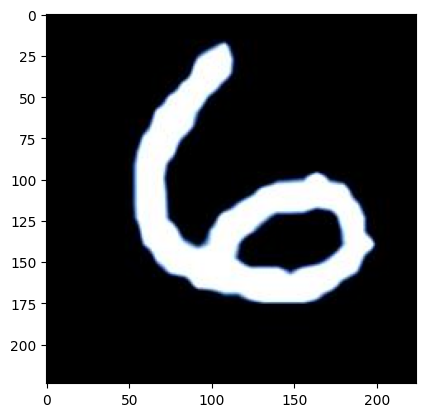

In [21]:
loader = LuxonisLoader(dataset)
for img, _ in loader:
    plt.imshow(img)
    plt.show()
    break

In [22]:
# Initialize the ONNX Runtime session for the model
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

2024-01-16 15:19:08.774233534 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [23]:
# Setup Weaviate
weaviate_api = WeaviateAPI("http://localhost:8080")
weaviate_api.create_collection("Mnist_LDF", label=True)

Collection Mnist_LDF does not exist. Creating...


In [24]:
# Load the LuxonisDataset
emb_dict = generate_embeddings_weaviate(
    dataset, ort_session, weaviate_api, output_layer_name="/Flatten_output_0"
)

Upserted 6400 of embeddings to Weaviate.
Embeddings generation and insertion completed!


In [25]:
first_emb = None

# get a specific sample from dataset
first_sample = list(emb_dict.keys())[0]
first_emb = emb_dict[first_sample]
sample_id = first_sample

# sample_id = '64e758bdca1096d3483d18f4'
# sample = dataset.fo_dataset[sample_id]
df = dataset._load_df_offline()
sample = df[df["instance_id"] == sample_id]
print(sample)

          file class            type value  \
0  mnist_0.jpg     9  classification  True   

                            instance_id value_type                 created_at  
0  d48fd3e2-90b2-51ed-a354-1e81d039b8d5       bool 2024-01-16 15:19:08.161648  


In [26]:
# Search for the nearest neighbors
search_uuids = weaviate_api.find_similar_embeddings(first_emb, k=5)
search_labels = weaviate_api.get_labels(search_uuids)

# Print the search results
for u,l in zip(search_uuids, search_labels):
    print(u, l)

d48fd3e2-90b2-51ed-a354-1e81d039b8d5 9
79353146-6e82-5f7a-ab42-cf5607cdcf6d 9
8a518f3e-f64b-5ac8-b7dc-4c6eb803b0d1 9
47042d29-69d0-5159-ac39-8d33e00992dc 9
532966db-ccca-5082-8228-6cd45e924716 9


## Embeddings Processing

In [27]:
# look at the Embeddings_Processing_Example.ipynb for the rest of the code

## Remove everything

In [30]:
# ! rm -rf ./mnist_images
# ! rm -rf ./mnist
# ! rm ./resnet50.onnx
# ! rm ./resnet50-1.onnx
# ! rm ./embeddings.pth
# ! rm ./labels.pth


E0116 15:28:35.876758443 2480934 backup_poller.cc:127]                 Run client channel backup poller: UNKNOWN:pollset_work {created_time:"2024-01-16T15:28:35.876634986+00:00", children:[UNKNOWN:Bad file descriptor {created_time:"2024-01-16T15:28:35.876588272+00:00", errno:9, os_error:"Bad file descriptor", syscall:"epoll_wait"}]}


In [ ]:
# # Delete the collection
# weaviate_api.delete_collection()

In [31]:
# # Delete the Luxonis ML dataset
# dataset.delete_dataset()